# Illustration using a 1-dimensional problem

Import relevant packages

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

%matplotlib inline

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False

Define a function to calculate the training loss as $(x-1)^2 + \lambda x^2$

In [8]:
def trn_loss(x,l):
    return (x-1)**2 + l*x**2

Define a function to calculate the validation loss as $(x-0.5)^2$

In [9]:
def val_loss(x):
    return (x-0.5)**2

Define the ground-truth hypergradient as $\frac{(\lambda-1)}{(\lambda+1)^3}$

In [3]:
def gt_grad(l):
    return (l-1)/(l+1)**3

Initialize a set of $\lambda$ values between 0.1 and 2

In [4]:
lmb = np.linspace(0.1, 2.0, 100)

Define parameters for EvoGrad gradient calculation as well as a function to do the calculation of EvoGrad

In [6]:
sigma = 1.0
n_trials = 100

In [10]:
def calc_grad(temperature, n_model_candidates):
    grads = []
    for i in range(len(lmb)):
        grads.append([])
        l = torch.tensor(lmb[i], requires_grad=True)
        for j in range(n_trials):
            # randomly generate the value of x
            x = torch.randn(1)
            # perturb the model parameters
            theta_list = torch.cat([x + sigma * torch.randn_like(x) for _ in range(n_model_candidates)])
            # calculate loss of the model copies
            loss_list = trn_loss(theta_list, l)
            # calculate the model copies weights
            weights = torch.softmax(-loss_list / temperature, 0)
            # merge the model copies
            theta_updated = sum(weights * theta_list)
            # evaluate the merged model on validation
            loss_val = val_loss(theta_updated)
            # calculate the hypergradient
            hyper_grad = torch.autograd.grad(loss_val, l)[0]
            grads[-1].append(hyper_grad.detach().numpy())
    grad = np.stack(grads)
    return grad

Study of how well the EvoGrad hypergradient matches the ground-truth hypergradient for various numbers of models in the population:

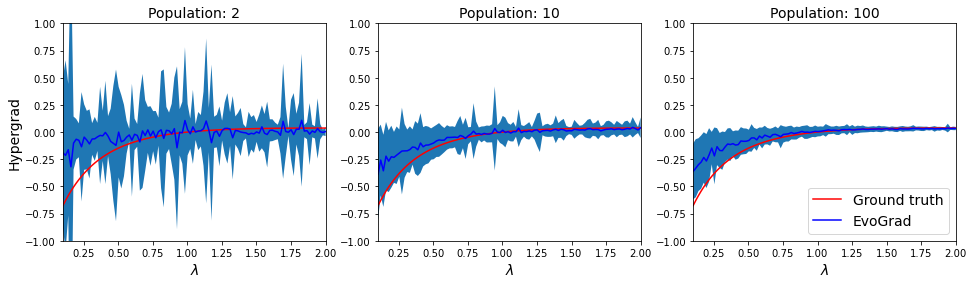

In [23]:
plt.figure(figsize=(16,4))
temperature = 0.5
torch.manual_seed(1)
plt.subplot(131)
n_model_candidates = 2
grad = calc_grad(temperature, n_model_candidates)
plt.plot(lmb, gt_grad(lmb),'r')
plt.plot(lmb, grad.mean(1),'b')
plt.fill_between(lmb, grad.mean(1)-grad.std(1), grad.mean(1)+grad.std(1))
plt.title('Population: ' + str(n_model_candidates), fontsize=14)
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel('Hypergrad', fontsize=14)
plt.ylim([-1, 1])
plt.xlim([0.1, 2])

plt.subplot(132)
n_model_candidates = 10
grad = calc_grad(temperature, n_model_candidates)
plt.plot(lmb, gt_grad(lmb),'r')
plt.plot(lmb, grad.mean(1),'b')
plt.fill_between(lmb, grad.mean(1)-grad.std(1), grad.mean(1)+grad.std(1))
plt.title('Population: ' + str(n_model_candidates), fontsize=14)
plt.xlabel('$\lambda$', fontsize=14)
plt.ylim([-1, 1])
plt.xlim([0.1, 2])

plt.subplot(133)
n_model_candidates = 100
grad = calc_grad(temperature, n_model_candidates)
plt.plot(lmb, gt_grad(lmb),'r')
plt.plot(lmb, grad.mean(1),'b')
plt.fill_between(lmb, grad.mean(1)-grad.std(1), grad.mean(1)+grad.std(1))
plt.title('Population: ' + str(n_model_candidates), fontsize=14)
plt.xlabel('$\lambda$', fontsize=14)
plt.ylim([-1, 1])
plt.xlim([0.1, 2])
plt.legend(['Ground truth', 'EvoGrad'], fontsize=14, loc='lower right')
plt.savefig("toy1dGradsEval.pdf", bbox_inches='tight')
plt.show()

Study of the trajectories of $x, \lambda$ when they are optimized with SGD and hypergradient estimated by EvoGrad: 

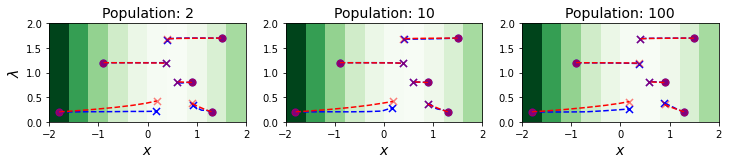

In [41]:
extent = [-2, 2, 0, 2]
val_loss_regions = [val_loss(np.linspace(-2.0, 2.0, 10)) for e in range(10)]
plt.figure(figsize=(12,6))
n_model_candidates = 2
plt.subplot(131)
plt.imshow(val_loss_regions, cmap='Greens', interpolation='nearest',
           extent=extent)
ll_init_list = [0.2, 1.2, 0.8, 0.2, 1.7]
xl_init_list = [-1.8, -0.9, 0.9, 1.3, 1.5]
num_inits = 5
markers = ['D', 'D', '*', '*', 'x']
num_steps = 5
sigma=1.0
temperature = 0.5
lr = 0.1

torch.manual_seed(1)

for e in range(num_inits):
    # initialize the values of lambda and x local to the current initialization
    ll = torch.tensor([ll_init_list[e]], requires_grad=True)
    xl = torch.tensor([xl_init_list[e]], requires_grad=True)
    # we will also track the ground-truth trajectories
    ll_gt = torch.tensor([ll_init_list[e]], requires_grad=True)
    xl_gt = torch.tensor([xl_init_list[e]], requires_grad=True)

    xl_traj = [xl.detach().numpy()]
    ll_traj = [ll.detach().numpy()]
    xl_traj_gt = [xl_gt.detach().numpy()]
    ll_traj_gt = [ll_gt.detach().numpy()]

    plt.scatter(xl.detach().numpy(), ll.detach().numpy(), marker='o', s=50, c='blue', alpha=1.0)
    plt.scatter(xl_gt.detach().numpy(), ll_gt.detach().numpy(), marker='o', s=50, c='red', alpha=0.5)

    for step in range(num_steps):
        # update x
        xl = xl - lr * torch.autograd.grad(trn_loss(xl, ll), xl)[0]
        xl_gt = xl_gt - lr * torch.autograd.grad(trn_loss(xl_gt, ll_gt), xl_gt)[0]

        # evoGrad update with multiple model copies
        theta_list = torch.cat([xl + sigma * torch.randn_like(xl) for _ in range(n_model_candidates)])
        loss_list = trn_loss(theta_list, ll)
        weights = torch.softmax(-loss_list / temperature, 0)
        theta_updated = sum(weights*theta_list)
        loss_val = val_loss(theta_updated)
        hyper_grad = torch.autograd.grad(loss_val, ll)[0]
        # update lambda using the hypergradient
        ll = ll - lr * hyper_grad
        ll_gt = ll_gt - lr * gt_grad(ll)
        
        xl_traj.append([xl.detach().numpy()])
        ll_traj.append([ll.detach().numpy()])
        xl_traj_gt.append([xl_gt.detach().numpy()])
        ll_traj_gt.append([ll_gt.detach().numpy()])

    plt.plot(xl_traj, ll_traj, c='blue', ls='--')
    plt.plot(xl_traj_gt, ll_traj_gt, c='red', ls='--')
    plt.scatter(xl.detach().numpy(), ll.detach().numpy(), marker=markers[step], s=50, c='blue', alpha=1.0)
    plt.scatter(xl_gt.detach().numpy(), ll_gt.detach().numpy(), marker=markers[step], s=50, c='red', alpha=0.5)

plt.xlabel('$x$', fontsize=14)
plt.ylabel('$\lambda$', fontsize=14)
plt.title('Population: ' + str(n_model_candidates), fontsize=14)

n_model_candidates = 10
plt.subplot(132)
plt.imshow(val_loss_regions, cmap='Greens', interpolation='nearest',
           extent=extent)
for e in range(num_inits):
    ll = torch.tensor([ll_init_list[e]], requires_grad=True)
    xl = torch.tensor([xl_init_list[e]], requires_grad=True)
    ll_gt = torch.tensor([ll_init_list[e]], requires_grad=True)
    xl_gt = torch.tensor([xl_init_list[e]], requires_grad=True)

    xl_traj = [xl.detach().numpy()]
    ll_traj = [ll.detach().numpy()]
    xl_traj_gt = [xl_gt.detach().numpy()]
    ll_traj_gt = [ll_gt.detach().numpy()]

    plt.scatter(xl.detach().numpy(), ll.detach().numpy(), marker='o', s=50, c='blue', alpha=1.0)
    plt.scatter(xl_gt.detach().numpy(), ll_gt.detach().numpy(), marker='o', s=50, c='red', alpha=0.5)

    for step in range(num_steps):
        xl = xl - lr * torch.autograd.grad(trn_loss(xl, ll), xl)[0]
        xl_gt = xl_gt - lr * torch.autograd.grad(trn_loss(xl_gt, ll_gt), xl_gt)[0]

        theta_list = torch.cat([xl + sigma * torch.randn_like(xl) for _ in range(n_model_candidates)])
        loss_list = trn_loss(theta_list, ll)
        weights = torch.softmax(-loss_list / temperature, 0)
        theta_updated = sum(weights * theta_list)
        loss_val = val_loss(theta_updated)
        hyper_grad = torch.autograd.grad(loss_val, ll)[0]
        ll = ll - lr * hyper_grad
        ll_gt = ll_gt - lr * gt_grad(ll)
        
        xl_traj.append([xl.detach().numpy()])
        ll_traj.append([ll.detach().numpy()])
        xl_traj_gt.append([xl_gt.detach().numpy()])
        ll_traj_gt.append([ll_gt.detach().numpy()])

    plt.plot(xl_traj, ll_traj, c='blue', ls='--')
    plt.plot(xl_traj_gt, ll_traj_gt, c='red', ls='--')
    plt.scatter(xl.detach().numpy(), ll.detach().numpy(), marker=markers[step], s=50, c='blue', alpha=1.0)
    plt.scatter(xl_gt.detach().numpy(), ll_gt.detach().numpy(), marker=markers[step], s=50, c='red', alpha=0.5)

plt.xlabel('$x$', fontsize=14)
plt.title('Population: ' + str(n_model_candidates), fontsize=14)

n_model_candidates = 100
plt.subplot(133)
im = plt.imshow(val_loss_regions, cmap='Greens', interpolation='nearest',
           extent=extent)
for e in range(num_inits):
    ll = torch.tensor([ll_init_list[e]], requires_grad=True)
    xl = torch.tensor([xl_init_list[e]], requires_grad=True)
    ll_gt = torch.tensor([ll_init_list[e]], requires_grad=True)
    xl_gt = torch.tensor([xl_init_list[e]], requires_grad=True)

    xl_traj = [xl.detach().numpy()]
    ll_traj = [ll.detach().numpy()]
    xl_traj_gt = [xl_gt.detach().numpy()]
    ll_traj_gt = [ll_gt.detach().numpy()]

    plt.scatter(xl.detach().numpy(), ll.detach().numpy(), marker='o', s=50, c='blue', alpha=1.0)
    plt.scatter(xl_gt.detach().numpy(), ll_gt.detach().numpy(), marker='o', s=50, c='red', alpha=0.5)

    for step in range(num_steps):
        xl = xl - lr * torch.autograd.grad(trn_loss(xl, ll), xl)[0]
        xl_gt = xl_gt - lr * torch.autograd.grad(trn_loss(xl_gt, ll_gt), xl_gt)[0]

        theta_list = torch.cat([xl + sigma * torch.randn_like(xl) for _ in range(n_model_candidates)])
        loss_list = trn_loss(theta_list, ll)
        weights = torch.softmax(-loss_list / temperature, 0)
        theta_updated = sum(weights * theta_list)
        loss_val = val_loss(theta_updated)
        hyper_grad = torch.autograd.grad(loss_val, ll)[0]
        ll = ll - lr * hyper_grad
        ll_gt = ll_gt - lr * gt_grad(ll)
        
        xl_traj.append([xl.detach().numpy()])
        ll_traj.append([ll.detach().numpy()])
        xl_traj_gt.append([xl_gt.detach().numpy()])
        ll_traj_gt.append([ll_gt.detach().numpy()])

    plt.plot(xl_traj, ll_traj, c='blue', ls='--')
    plt.plot(xl_traj_gt, ll_traj_gt, c='red', ls='--')
    plt.scatter(xl.detach().numpy(), ll.detach().numpy(), marker=markers[step], s=50, c='blue', alpha=1.0)
    plt.scatter(xl_gt.detach().numpy(), ll_gt.detach().numpy(), marker=markers[step], s=50, c='red', alpha=0.5)
plt.title('Population: ' + str(n_model_candidates), fontsize=14)
plt.xlabel('$x$', fontsize=14)
plt.savefig("toy1dTrajectoriesPlotLines.pdf", bbox_inches='tight')
plt.show()